In [5]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import scienceplots
from cmap import Colormap

In [6]:
N_COLLOCATION_POINTS = 10_000
N_IC_POINTS = 300
N_BC_POINTS = 300

LEARNING_RATE = 0.001
N_OPTIMIZATION_EPOCHS = 20_000

XMIN = -1.0
XMAX = 1.0
TMIN = 0.0
TMAX = 1.0

In [27]:
v = 0.01
a = 5
def exact(x, t):
    eterm = jnp.exp(-jnp.pi**2 * v* t)
    
    return (2 * v * jnp.pi * eterm * jnp.sin(jnp.pi * x)) / (a + eterm * jnp.cos(jnp.pi * x))

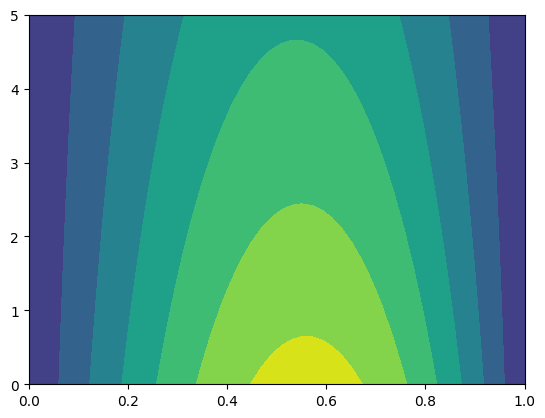

In [28]:
xs = jnp.linspace(0, 1)
ts = jnp.linspace(0, 5)
X, T = jnp.meshgrid(xs, ts)
U = exact(X, T)
plt.contourf(X, T, U)

In [8]:
key = jr.PRNGKey(42)

In [9]:
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size=3,
    out_size=3,
    width_size=40,
    depth=4,
    activation=jax.nn.sigmoid,
    key=key,
)

In [10]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

In [ ]:
@eqx.filter_jit
def loss_fn(network):
    pde_res_coll = jax.vmap(pde_residuum, in_axes=(None, 0))(network, coll_points)
    pde_loss = jnp.mean(jnp.square(pde_res_coll))
    
    data_res = jax.vmap(data_residuum, in_axes=(None, 0))(network, data_points)
    data_loss = jnp.mean(jnp.square(data_res))
    
    total_loss = 0.5 * (pde_loss + DATA_LOSS_WEIGHT * data_loss)
    
    return total_loss

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss